 Kütüphaneler başarıyla yüklendi!
MÜŞTERİ SEGMENTASYONU ANALİZİ BAŞLIYOR!
 Veri yükleniyor ve analiz ediliyor...
 Veri başarıyla yüklendi!
 Veri boyutu: (2240, 29)
 Sütun sayısı: 29
 Eksik değer sayısı: 24
 Sayısal sütun sayısı: 26

 İlk 5 satır:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4      

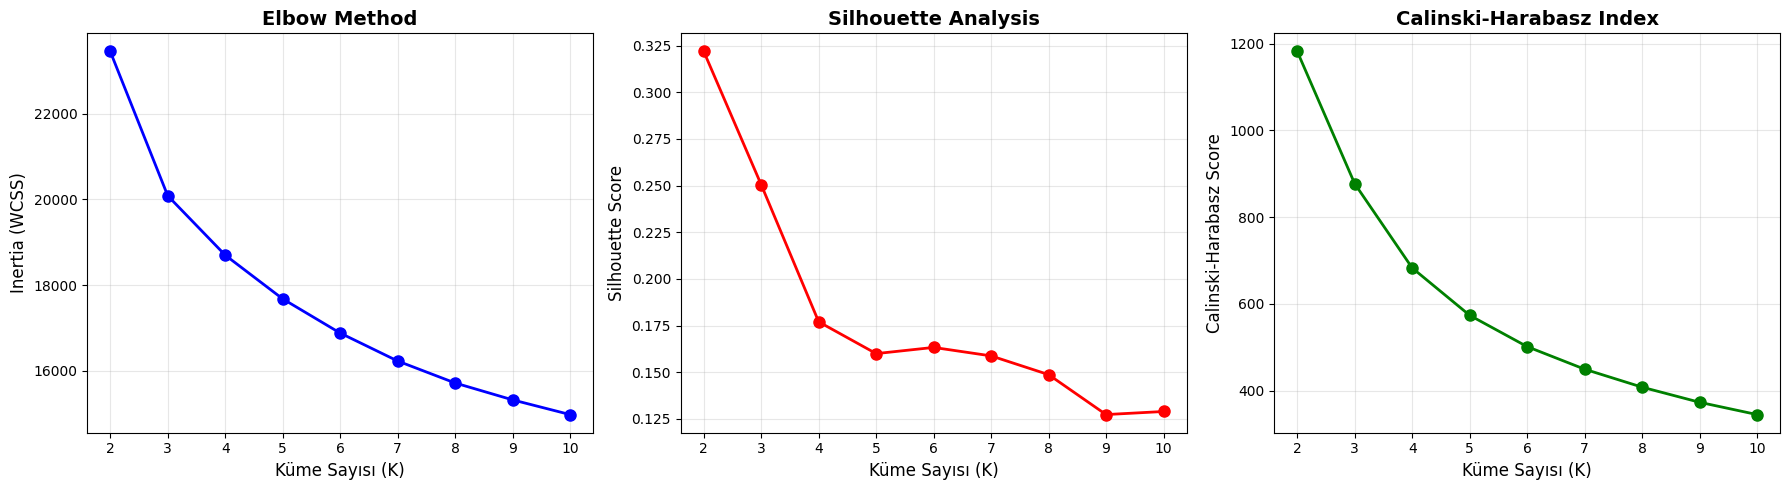


 Önerilen optimal küme sayısı: 2
 Bu K değeri için Silhouette Score: 0.322

 Kümeleme algoritmaları çalıştırılıyor...
 KMeans analizi...
  K=3: Sil=0.250, CH=877.2, DB=1.634
  K=4: Sil=0.177, CH=683.1, DB=1.781
  K=5: Sil=0.160, CH=573.8, DB=2.125
 Hierarchical Clustering analizi...
  K=3: Sil=0.234, CH=798.7, DB=1.698
  K=4: Sil=0.212, CH=615.2, DB=2.293
  K=5: Sil=0.140, CH=528.2, DB=2.252
 DBSCAN analizi...
  Eps=0.5: Clusters=2, Noise=2227, Sil=-0.168
  Eps=1.0: Clusters=10, Noise=1718, Sil=-0.109
  Eps=1.5: Clusters=7, Noise=1250, Sil=0.023

 Algoritma performansları karşılaştırılıyor...

 PERFORMANS KARŞILAŞTIRMA TABLOSU
   Algorithm Parameter  Clusters Silhouette  Calinski-Harabasz  Davies-Bouldin
      KMEANS       K=3         3       0.25              877.2           1.634
      KMEANS       K=4         4      0.177              683.1           1.781
      KMEANS       K=5         5       0.16              573.8           2.125
HIERARCHICAL       K=3         3      0.234     

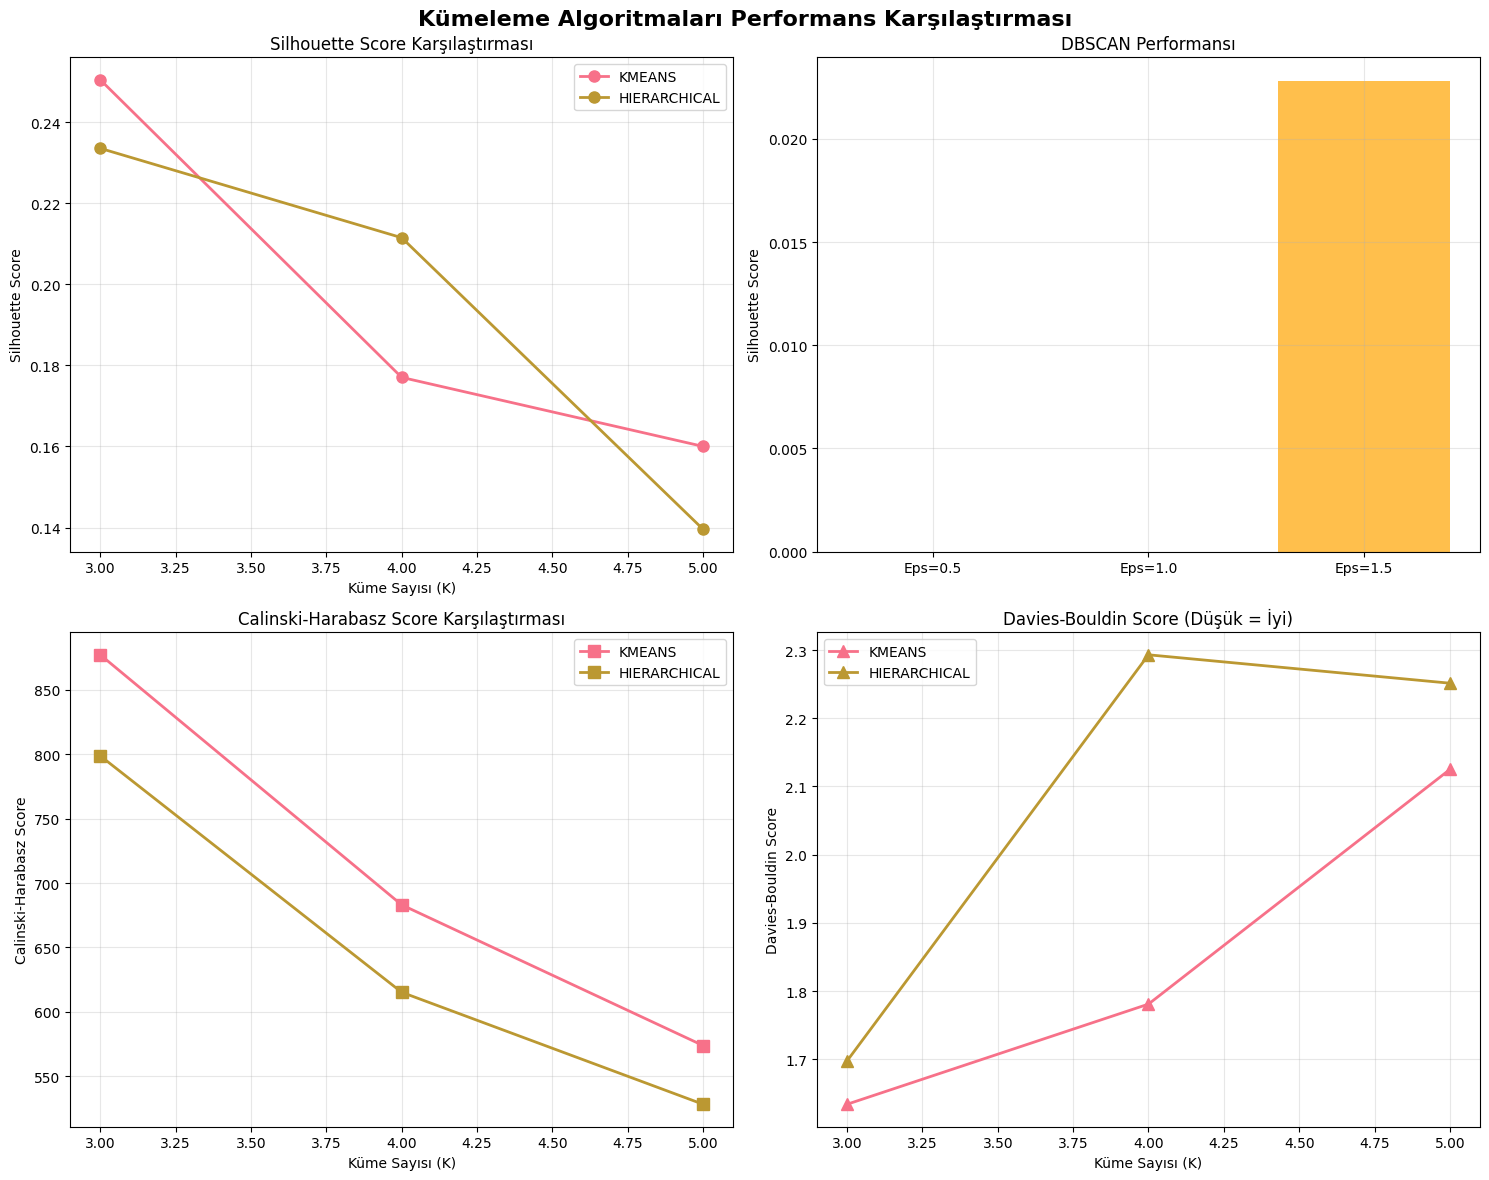


 EN İYİ SONUÇ:
   Algorithm: KMEANS
   Parameter: 3
   Silhouette Score: 0.250
   Calinski-Harabasz: 877.2
   Davies-Bouldin: 1.634

 Kümeleme sonuçları görselleştiriliyor...


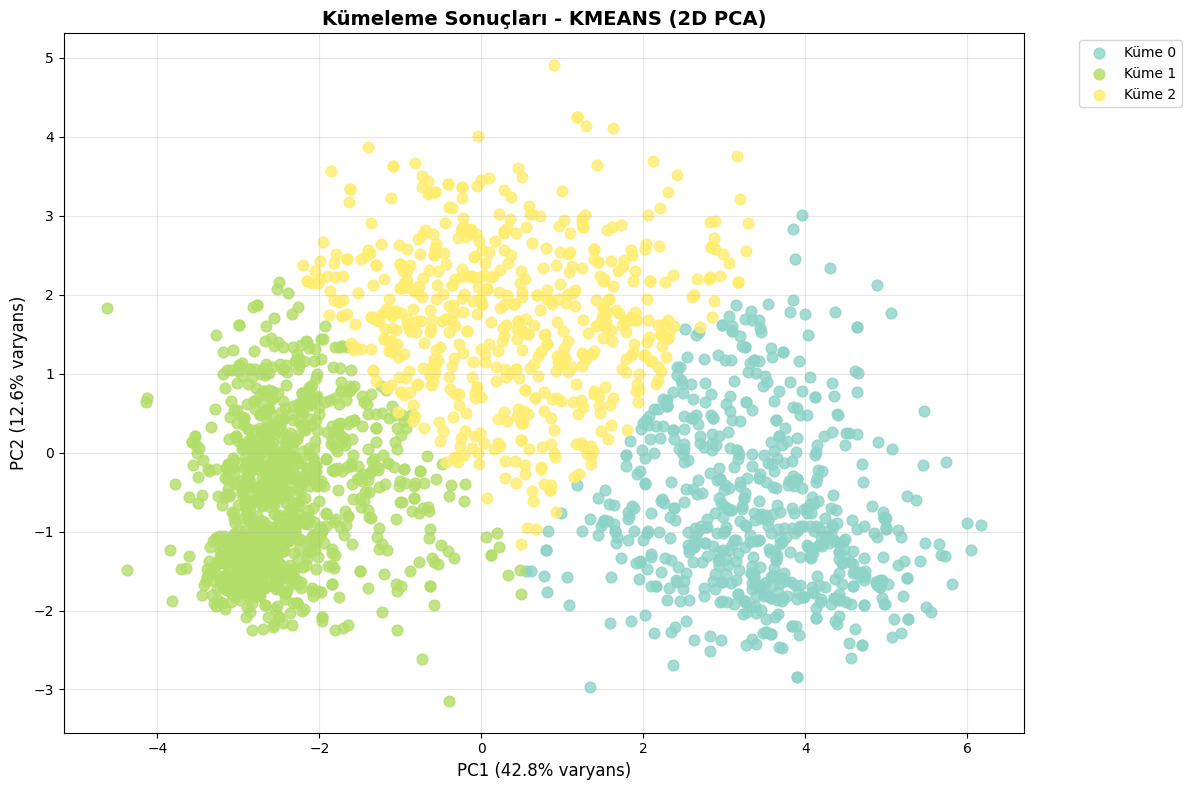

 PCA ile açıklanan toplam varyans: 55.4%

 ANALİZ TAMAMLANDI!


In [12]:
# Gerekli kütüphaneleri yükle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Grafik ayarları
plt.style.use('default')
sns.set_palette("husl")

print(" Kütüphaneler başarıyla yüklendi!")

# =============================================================================
# VERİ YÜKLEME VE ÖN İŞLEME FONKSİYONLARI
# =============================================================================

def load_and_explore_data(file_path):

    print(" Veri yükleniyor ve analiz ediliyor...")

    # Veri yükleme
    df = pd.read_csv(file_path)

    # Temel bilgiler
    print(f" Veri başarıyla yüklendi!")
    print(f" Veri boyutu: {df.shape}")
    print(f" Sütun sayısı: {len(df.columns)}")
    print(f" Eksik değer sayısı: {df.isnull().sum().sum()}")
    print(f" Sayısal sütun sayısı: {len(df.select_dtypes(include=[np.number]).columns)}")

    # İlk 5 satırı göster
    print("\n İlk 5 satır:")
    print(df.head())

    # Temel istatistikler
    print("\n Temel İstatistikler:")
    print(df.describe())

    return df

def preprocess_data(df, exclude_columns=None, handle_outliers=True, scaling_method='standard'):

    print("\n Veri ön işleme başlıyor...")

    # Sayısal sütunları seç
    df_clean = df.select_dtypes(include=[np.number]).copy()

    # Varsayılan çıkarılacak sütunlar
    default_exclude = ['ID', 'Z_CostContact', 'Z_Revenue', 'Unnamed: 0', 'index']
    if exclude_columns:
        default_exclude.extend(exclude_columns)

    # Sütunları çıkar
    df_clean = df_clean.drop(columns=default_exclude, errors='ignore')

    print(f" Kullanılan özellikler ({len(df_clean.columns)}): {list(df_clean.columns)}")

    # Eksik değerleri doldur
    initial_nulls = df_clean.isnull().sum().sum()
    if initial_nulls > 0:
        print(f" {initial_nulls} eksik değer medyan ile dolduruldu")
        df_clean = df_clean.fillna(df_clean.median())

    # Aykırı değerleri işle
    if handle_outliers:
        print(" Aykırı değerler işleniyor...")
        df_clean = handle_outliers_iqr(df_clean)

    # Normalizasyon
    if scaling_method == 'standard':
        scaler = StandardScaler()
        print(" Standard scaling uygulandı")
    elif scaling_method == 'robust':
        scaler = RobustScaler()
        print(" Robust scaling uygulandı")

    X_scaled = scaler.fit_transform(df_clean)

    print(f" Ön işleme tamamlandı! Final boyut: {X_scaled.shape}")

    return df_clean, X_scaled, scaler

def handle_outliers_iqr(df, threshold=1.5):
    """IQR yöntemiyle aykırı değerleri sınırla"""
    df_clean = df.copy()
    outlier_counts = {}

    for col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Aykırı değer sayısını say
        outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
        outlier_counts[col] = outliers

        # Aykırı değerleri sınırla
        df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)

    total_outliers = sum(outlier_counts.values())
    if total_outliers > 0:
        print(f" {total_outliers} aykırı değer düzeltildi")

    return df_clean

# =============================================================================
# OPTİMAL KÜME SAYISI BULMA
# =============================================================================

def find_optimal_clusters(X_scaled, k_range=range(2, 11)):
    """
    Elbow method ve Silhouette analysis ile optimal küme sayısını bul
    """
    print("\n Optimal küme sayısı araştırılıyor...")

    inertias = []
    silhouette_scores = []
    calinski_scores = []

    for k in k_range:
        # KMeans fit et
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, max_iter=300)
        labels = kmeans.fit_predict(X_scaled)

        # Metrikleri hesapla
        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)

        silhouette_scores.append(sil_score)
        calinski_scores.append(ch_score)

        print(f"K={k}: Silhouette={sil_score:.3f}, Inertia={kmeans.inertia_:.0f}")

    # Grafikler
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Elbow Method
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Küme Sayısı (K)', fontsize=12)
    axes[0].set_ylabel('Inertia (WCSS)', fontsize=12)
    axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Silhouette Score
    axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Küme Sayısı (K)', fontsize=12)
    axes[1].set_ylabel('Silhouette Score', fontsize=12)
    axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Calinski-Harabasz Score
    axes[2].plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=8)
    axes[2].set_xlabel('Küme Sayısı (K)', fontsize=12)
    axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=12)
    axes[2].set_title('Calinski-Harabasz Index', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Optimal k önerisi
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\n Önerilen optimal küme sayısı: {optimal_k}")
    print(f" Bu K değeri için Silhouette Score: {max(silhouette_scores):.3f}")

    return optimal_k, silhouette_scores, inertias

# =============================================================================
# KÜMELEME ALGORİTMALARI
# =============================================================================

def run_clustering_algorithms(X_scaled, k_values=[3, 4, 5], eps_values=[0.5, 1.0, 1.5]):
    """
    Farklı kümeleme algoritmaları çalıştır ve sonuçları karşılaştır
    """
    print("\n Kümeleme algoritmaları çalıştırılıyor...")

    results = {}

    # 1. KMeans
    print(" KMeans analizi...")
    results['kmeans'] = run_kmeans_analysis(X_scaled, k_values)

    # 2. Hierarchical Clustering
    print(" Hierarchical Clustering analizi...")
    results['hierarchical'] = run_hierarchical_analysis(X_scaled, k_values)

    # 3. DBSCAN
    print(" DBSCAN analizi...")
    results['dbscan'] = run_dbscan_analysis(X_scaled, eps_values)

    return results

def run_kmeans_analysis(X_scaled, k_values):
    """KMeans analizi"""
    results = {}

    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, max_iter=300)
        labels = kmeans.fit_predict(X_scaled)

        # Metrikleri hesapla
        sil_score = silhouette_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)

        results[k] = {
            'labels': labels,
            'silhouette': sil_score,
            'calinski_harabasz': ch_score,
            'davies_bouldin': db_score,
            'model': kmeans,
            'n_clusters': k
        }

        print(f"  K={k}: Sil={sil_score:.3f}, CH={ch_score:.1f}, DB={db_score:.3f}")

    return results

def run_hierarchical_analysis(X_scaled, k_values):
    """Hierarchical Clustering analizi"""
    results = {}

    for k in k_values:
        hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = hierarchical.fit_predict(X_scaled)

        sil_score = silhouette_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)

        results[k] = {
            'labels': labels,
            'silhouette': sil_score,
            'calinski_harabasz': ch_score,
            'davies_bouldin': db_score,
            'model': hierarchical,
            'n_clusters': k
        }

        print(f"  K={k}: Sil={sil_score:.3f}, CH={ch_score:.1f}, DB={db_score:.3f}")

    return results

def run_dbscan_analysis(X_scaled, eps_values):
    """DBSCAN analizi"""
    results = {}

    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(X_scaled)

        # Küme bilgileri
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Geçerli kümeleme kontrolü
        if n_clusters > 1 and n_clusters < len(X_scaled):
            sil_score = silhouette_score(X_scaled, labels)
            ch_score = calinski_harabasz_score(X_scaled, labels)
            db_score = davies_bouldin_score(X_scaled, labels)
        else:
            sil_score = ch_score = db_score = -1

        results[eps] = {
            'labels': labels,
            'silhouette': sil_score,
            'calinski_harabasz': ch_score,
            'davies_bouldin': db_score,
            'model': dbscan,
            'n_clusters': n_clusters,
            'n_noise': n_noise
        }

        print(f"  Eps={eps}: Clusters={n_clusters}, Noise={n_noise}, Sil={sil_score:.3f}")

    return results

# =============================================================================
# SONUÇLARI KARŞILAŞTIRMA VE GÖRSELLEŞTİRME
# =============================================================================

def compare_algorithms(results):
    """Algoritmaları karşılaştır"""
    print("\n Algoritma performansları karşılaştırılıyor...")

    # Performans tablosu oluştur
    create_performance_table(results)

    # Karşılaştırma grafiği
    plot_algorithm_comparison(results)

    return find_best_algorithm(results)

def create_performance_table(results):
    """Performans tablosu oluştur"""
    performance_data = []

    # KMeans ve Hierarchical
    for alg_name in ['kmeans', 'hierarchical']:
        if alg_name in results:
            for k, scores in results[alg_name].items():
                performance_data.append({
                    'Algorithm': alg_name.upper(),
                    'Parameter': f'K={k}',
                    'Clusters': scores['n_clusters'],
                    'Silhouette': round(scores['silhouette'], 3),
                    'Calinski-Harabasz': round(scores['calinski_harabasz'], 1),
                    'Davies-Bouldin': round(scores['davies_bouldin'], 3)
                })

    # DBSCAN
    if 'dbscan' in results:
        for eps, scores in results['dbscan'].items():
            performance_data.append({
                'Algorithm': 'DBSCAN',
                'Parameter': f'Eps={eps}',
                'Clusters': scores['n_clusters'],
                'Silhouette': round(scores['silhouette'], 3) if scores['silhouette'] > 0 else 'N/A',
                'Calinski-Harabasz': round(scores['calinski_harabasz'], 1) if scores['calinski_harabasz'] > 0 else 'N/A',
                'Davies-Bouldin': round(scores['davies_bouldin'], 3) if scores['davies_bouldin'] > 0 else 'N/A'
            })

    df_performance = pd.DataFrame(performance_data)
    print("\n PERFORMANS KARŞILAŞTIRMA TABLOSU")
    print("=" * 80)
    print(df_performance.to_string(index=False))
    print("=" * 80)

def plot_algorithm_comparison(results):
    """Algoritma karşılaştırma grafikleri"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Kümeleme Algoritmaları Performans Karşılaştırması', fontsize=16, fontweight='bold')

    # Silhouette Score karşılaştırması
    ax1 = axes[0, 0]
    for alg_name in ['kmeans', 'hierarchical']:
        if alg_name in results:
            k_vals = list(results[alg_name].keys())
            sil_scores = [results[alg_name][k]['silhouette'] for k in k_vals]
            ax1.plot(k_vals, sil_scores, 'o-', label=alg_name.upper(), linewidth=2, markersize=8)

    ax1.set_xlabel('Küme Sayısı (K)')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Score Karşılaştırması')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # DBSCAN ayrı grafik
    ax2 = axes[0, 1]
    if 'dbscan' in results:
        eps_vals = list(results['dbscan'].keys())
        sil_scores = [results['dbscan'][eps]['silhouette'] if results['dbscan'][eps]['silhouette'] > 0 else 0
                     for eps in eps_vals]
        ax2.bar(range(len(eps_vals)), sil_scores, alpha=0.7, color='orange')
        ax2.set_xticks(range(len(eps_vals)))
        ax2.set_xticklabels([f'Eps={eps}' for eps in eps_vals])
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('DBSCAN Performansı')
        ax2.grid(True, alpha=0.3)

    # Calinski-Harabasz Score
    ax3 = axes[1, 0]
    for alg_name in ['kmeans', 'hierarchical']:
        if alg_name in results:
            k_vals = list(results[alg_name].keys())
            ch_scores = [results[alg_name][k]['calinski_harabasz'] for k in k_vals]
            ax3.plot(k_vals, ch_scores, 's-', label=alg_name.upper(), linewidth=2, markersize=8)

    ax3.set_xlabel('Küme Sayısı (K)')
    ax3.set_ylabel('Calinski-Harabasz Score')
    ax3.set_title('Calinski-Harabasz Score Karşılaştırması')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Davies-Bouldin Score (düşük daha iyi)
    ax4 = axes[1, 1]
    for alg_name in ['kmeans', 'hierarchical']:
        if alg_name in results:
            k_vals = list(results[alg_name].keys())
            db_scores = [results[alg_name][k]['davies_bouldin'] for k in k_vals]
            ax4.plot(k_vals, db_scores, '^-', label=alg_name.upper(), linewidth=2, markersize=8)

    ax4.set_xlabel('Küme Sayısı (K)')
    ax4.set_ylabel('Davies-Bouldin Score')
    ax4.set_title('Davies-Bouldin Score (Düşük = İyi)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def find_best_algorithm(results):
    """En iyi algoritmayı bul ve öner"""
    best_configs = []

    # Tüm konfigürasyonları değerlendir
    for alg_name in ['kmeans', 'hierarchical']:
        if alg_name in results:
            for k, scores in results[alg_name].items():
                best_configs.append({
                    'algorithm': alg_name,
                    'parameter': k,
                    'silhouette': scores['silhouette'],
                    'calinski_harabasz': scores['calinski_harabasz'],
                    'davies_bouldin': scores['davies_bouldin']
                })

    if 'dbscan' in results:
        for eps, scores in results['dbscan'].items():
            if scores['silhouette'] > 0:  # Geçerli kümeleme
                best_configs.append({
                    'algorithm': 'dbscan',
                    'parameter': eps,
                    'silhouette': scores['silhouette'],
                    'calinski_harabasz': scores['calinski_harabasz'],
                    'davies_bouldin': scores['davies_bouldin']
                })

    # En iyi Silhouette score'a göre sırala
    best_configs.sort(key=lambda x: x['silhouette'], reverse=True)

    if best_configs:
        best = best_configs[0]
        print(f"\n EN İYİ SONUÇ:")
        print(f"   Algorithm: {best['algorithm'].upper()}")
        print(f"   Parameter: {best['parameter']}")
        print(f"   Silhouette Score: {best['silhouette']:.3f}")
        print(f"   Calinski-Harabasz: {best['calinski_harabasz']:.1f}")
        print(f"   Davies-Bouldin: {best['davies_bouldin']:.3f}")

        return best

    return None

def visualize_clusters_2d(X_scaled, df_clean, results, best_config):
    """PCA ile 2D görselleştirme"""
    print("\n Kümeleme sonuçları görselleştiriliyor...")

    # PCA ile boyut indirgeme
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # En iyi modelin etiketlerini al
    if best_config['algorithm'] in ['kmeans', 'hierarchical']:
        best_labels = results[best_config['algorithm']][best_config['parameter']]['labels']
    else:
        best_labels = results[best_config['algorithm']][best_config['parameter']]['labels']

    # Görselleştirme
    plt.figure(figsize=(12, 8))

    # Kümeler
    unique_labels = np.unique(best_labels)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        if label == -1:  # DBSCAN noise points
            plt.scatter(X_pca[best_labels == label, 0], X_pca[best_labels == label, 1],
                       c='black', marker='x', s=50, alpha=0.6, label='Noise')
        else:
            plt.scatter(X_pca[best_labels == label, 0], X_pca[best_labels == label, 1],
                       c=[color], s=60, alpha=0.8, label=f'Küme {label}')

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varyans)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varyans)', fontsize=12)
    plt.title(f'Kümeleme Sonuçları - {best_config["algorithm"].upper()} (2D PCA)',
              fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f" PCA ile açıklanan toplam varyans: {sum(pca.explained_variance_ratio_):.1%}")

# =============================================================================
# ANA ÇALIŞTIRMA FONKSİYONU
# =============================================================================

def main_analysis(file_path, k_values=[3, 4, 5], eps_values=[0.5, 1.0, 1.5]):

    print("MÜŞTERİ SEGMENTASYONU ANALİZİ BAŞLIYOR!")
    print("=" * 60)

    # 1. Veri yükleme ve keşif
    df = load_and_explore_data(file_path)

    # 2. Ön işleme
    df_clean, X_scaled, scaler = preprocess_data(df, handle_outliers=True, scaling_method='standard')

    # 3. Optimal küme sayısı bulma
    optimal_k, sil_scores, inertias = find_optimal_clusters(X_scaled)

    # 4. Kümeleme algoritmaları çalıştırma
    clustering_results = run_clustering_algorithms(X_scaled, k_values, eps_values)

    # 5. Sonuçları karşılaştırma
    best_config = compare_algorithms(clustering_results)

    # 6. Görselleştirme
    if best_config:
        visualize_clusters_2d(X_scaled, df_clean, clustering_results, best_config)

    print("\n ANALİZ TAMAMLANDI!")

    # Sonuçları döndür
    return {
        'original_data': df,
        'cleaned_data': df_clean,
        'scaled_data': X_scaled,
        'scaler': scaler,
        'clustering_results': clustering_results,
        'best_config': best_config,
        'optimal_k': optimal_k
    }

if __name__ == "__main__":
    file_path = "/content/customer_segmentation.csv"

    # Analizi başlat
    results = main_analysis(file_path)